# Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [2]:
# Data load
try:
    df_train = pd.read_csv('dataset_latihan.csv')
    df_test = pd.read_csv('dataset_tes_holdout.csv')
    print("Dataset Latihan dan Tes Holdout berhasil dimuat.")
except FileNotFoundError:
    print("ERROR: Pastikan file 'dataset_latihan.csv' dan 'dataset_tes_holdout.csv' ada.")
    exit()

Dataset Latihan dan Tes Holdout berhasil dimuat.


In [3]:
# Lakukan pengecekan dan feature engineering pada kedua dataframe
for name, df in [('Latihan', df_train), ('Tes Holdout', df_test)]:
    print(f"\n--- Memproses Dataset {name} ---")

    # Cek Missing Value
    if df.isnull().sum().sum() == 0:
        print("Tidak ada missing value.")
    else:
        print(f"Ditemukan missing value, harap ditangani.")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # Cek Duplikat
    duplicate_count = df.duplicated().sum()
    print(f"Jumlah baris duplikat: {duplicate_count}")
    if duplicate_count > 0:
        df.drop_duplicates(inplace=True)
        print("Baris duplikat telah dihapus.")

    # Feature Engineering
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

print("\nFeature engineering selesai untuk kedua dataset.")


--- Memproses Dataset Latihan ---
Tidak ada missing value.
Jumlah baris duplikat: 0

--- Memproses Dataset Tes Holdout ---
Tidak ada missing value.
Jumlah baris duplikat: 0

Feature engineering selesai untuk kedua dataset.


# Pemrosesan Data

In [4]:
# Definisikan fitur (X) dan target (y)
features_to_drop = ['transaction_id', 'sender_account', 'receiver_account', 'timestamp', 'is_synthetic', 'anomaly_type']

X_train = df_train.drop(columns=['is_fraud'] + features_to_drop)
y_train = df_train['is_fraud']

X_test = df_test.drop(columns=['is_fraud'] + features_to_drop)
y_test = df_test['is_fraud']

# Identifikasi kolom numerik dan kategorikal
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

In [5]:
#  PRAPEMROSESAN DATA
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [6]:
# fit HANYA pada data LATIHAN
print("\nMelatih preprocessor HANYA pada data latihan...")
preprocessor.fit(X_train)

# Terapkan preprocessor ke kedua set
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Bentuk data training setelah diproses: {X_train_processed.shape}")
print(f"Bentuk data testing setelah diproses: {X_test_processed.shape}")



Melatih preprocessor HANYA pada data latihan...
Bentuk data training setelah diproses: (2610, 19)
Bentuk data testing setelah diproses: (755, 19)


# Modelling

In [7]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

D:\Perkuliahan\Semester 6\MSIB\Capstone\DeteksiAnomali\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Hitung class weight dari data latihan
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass Weights yang digunakan: {class_weight_dict}")


Class Weights yang digunakan: {0: np.float64(0.815625), 1: np.float64(1.2920792079207921)}


In [9]:
print("\nMemulai pelatihan model...")
history = model.fit(
    X_train_processed, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    class_weight=class_weight_dict,
    verbose=1
)
print("Pelatihan model selesai.")


Memulai pelatihan model...
Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7072 - auc: 0.8768 - loss: 0.4817 - val_accuracy: 0.9748 - val_auc: 0.9987 - val_loss: 0.0646
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0189 - val_accuracy: 0.9894 - val_auc: 0.9998 - val_loss: 0.0241
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0028 - val_accuracy: 0.9934 - val_auc: 0.9999 - val_loss: 0.0205
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0012 - val_accuracy: 0.9947 - val_auc: 0.9999 - val_loss: 0.0148
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.5755e-04 - val_accuracy: 0.9947 - val_auc: 0.9999 - val_loss: 0.0142
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.0198e-04 - val_accuracy: 0.9947 - val_auc: 0.9999 - val_loss: 0.0144
Epoch 7/30
82/8

# Evaluasi


--- Grafik Performa Pelatihan (diuji pada Holdout Set) ---


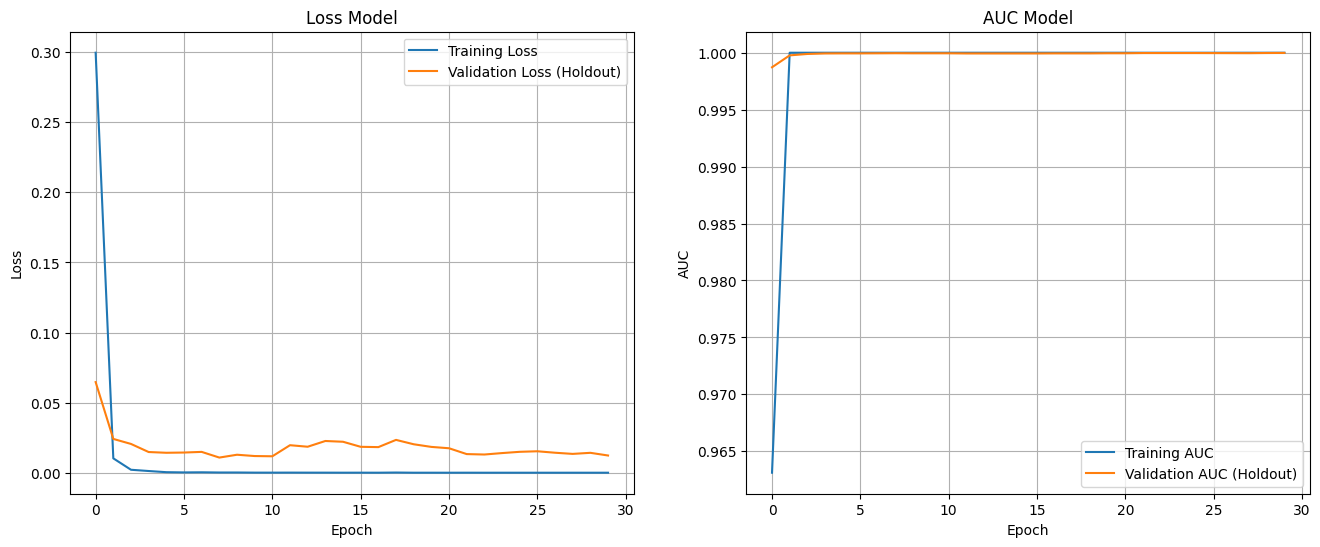

In [10]:
# --- Fungsi untuk plot grafik ---
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss (Holdout)')
    ax[0].set_title('Loss Model'); ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss'); ax[0].legend(); ax[0].grid(True)
    ax[1].plot(history.history['auc'], label='Training AUC')
    ax[1].plot(history.history['val_auc'], label='Validation AUC (Holdout)')
    ax[1].set_title('AUC Model'); ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('AUC'); ax[1].legend(); ax[1].grid(True)
    plt.show()

print("\n--- Grafik Performa Pelatihan (diuji pada Holdout Set) ---")
plot_training_history(history)

In [11]:
# Evaluasi final pada holdout set
print("\n--- HASIL EVALUASI FINAL PADA HOLDEM SET ---")
y_pred_proba = model.predict(X_test_processed).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nLaporan Klasifikasi (Holdout Set):")
print(classification_report(y_test, y_pred))


--- HASIL EVALUASI FINAL PADA HOLDEM SET ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Laporan Klasifikasi (Holdout Set):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.98      1.00      0.99       355

    accuracy                           0.99       755
   macro avg       0.99      0.99      0.99       755
weighted avg       0.99      0.99      0.99       755



ROC-AUC Score (Holdout Set): 1.0000

Confusion Matrix (Holdout Set):


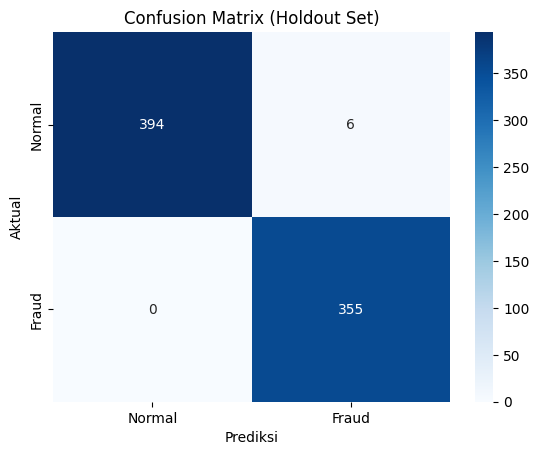

In [12]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score (Holdout Set): {roc_auc:.4f}")

print("\nConfusion Matrix (Holdout Set):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Prediksi'); plt.ylabel('Aktual'); plt.title('Confusion Matrix (Holdout Set)')
plt.show()

# Saved Model

In [13]:
print("\nMenyimpan model dan preprocessor...")
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# a. Simpan dalam format SavedModel (rekomendasi TensorFlow untuk deployment)
# Gunakan model.export() untuk SavedModel format
model.export(os.path.join(model_dir, 'model_savedmodel'))
print(f"Model disimpan dalam format SavedModel di direktori '{model_dir}/model_savedmodel'")

# b. Simpan dalam format Keras (.keras) - modern (untuk Keras/TensorFlow)
# Gunakan model.save() dengan ekstensi .keras
model.save(os.path.join(model_dir, 'model.keras'))
print(f"Model disimpan dalam format Keras di '{model_dir}/model.keras'")

# c. Simpan dalam format HDF5 (.h5) - legacy (untuk kompatibilitas)
# Gunakan model.save() dengan ekstensi .h5
model.save(os.path.join(model_dir, 'model.h5'))
print(f"Model disimpan dalam format H5 di '{model_dir}/model.h5'")

# d. Simpan preprocessor menggunakan joblib
preprocessor_path = os.path.join(model_dir, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor disimpan di '{preprocessor_path}'")

# %%


Menyimpan model dan preprocessor...
INFO:tensorflow:Assets written to: saved_models\model_savedmodel\assets


INFO:tensorflow:Assets written to: saved_models\model_savedmodel\assets


Saved artifact at 'saved_models\model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 19), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2726722286416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722284112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722286992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722286800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722283920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722283152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722283536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2726722283728: TensorSpec(shape=(), dtype=tf.resource, name=None)


Model disimpan dalam format SavedModel di direktori 'saved_models/model_savedmodel'
Model disimpan dalam format Keras di 'saved_models/model.keras'
Model disimpan dalam format H5 di 'saved_models/model.h5'
Preprocessor disimpan di 'saved_models\preprocessor.joblib'


# Contoh Inferensi

In [14]:
print("\n--- Contoh Proses Inferensi ---")

# Muat kembali model dan preprocessor
# Muat model dari format .keras
model_path_keras = os.path.join(model_dir, 'model.keras')
loaded_model = tf.keras.models.load_model(model_path_keras)
loaded_preprocessor = joblib.load(preprocessor_path)
print("Model dan preprocessor berhasil dimuat kembali.")

# Buat contoh data baru (dengan aturan anomali dari holdout set)
new_data_holdout = pd.DataFrame({
    'amount': [8000000.0],
    'transaction_type': ['withdrawal'],
    'merchant_category': ['travel_agency'],
    'location': ['Nairobi'], # <-- Lokasi dari aturan holdout
    'hour_of_day': [14],
    'day_of_week': [2]
})

print("\nData baru untuk diprediksi (pola holdout):")
print(new_data_holdout)

# Terapkan preprocessor
new_data_processed = loaded_preprocessor.transform(new_data_holdout)

# Lakukan prediksi
prediction_proba = loaded_model.predict(new_data_processed)
prediction = (prediction_proba > 0.5).astype(int)

print(f"\nHasil Prediksi (Probabilitas): {prediction_proba[0][0]:.4f}")
if prediction[0][0] == 1:
    print("Kesimpulan: Transaksi terdeteksi sebagai ANOMALI (FRAUD)")
else:
    print("Kesimpulan: Transaksi terdeteksi sebagai NORMAL")


--- Contoh Proses Inferensi ---
Model dan preprocessor berhasil dimuat kembali.

Data baru untuk diprediksi (pola holdout):
      amount transaction_type merchant_category location  hour_of_day  \
0  8000000.0       withdrawal     travel_agency  Nairobi           14   

   day_of_week  
0            2  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

Hasil Prediksi (Probabilitas): 1.0000
Kesimpulan: Transaksi terdeteksi sebagai ANOMALI (FRAUD)


In [15]:
# Contoh kedua
new_data = pd.DataFrame({
    'amount': [250000.0],
    'transaction_type': ['withdrawal'],
    'merchant_category': ['groceries'],
    'location': ['Bandung'],
    'hour_of_day': [14],
    'day_of_week': [5]
})

print("\nData baru untuk diprediksi:")
print(new_data)

# --- 3. LAKUKAN PREDIKSI ---
# Terapkan preprocessor yang sudah dilatih ke data baru
new_data_processed = loaded_preprocessor.transform(new_data)

# Lakukan prediksi
prediction_proba = loaded_model.predict(new_data_processed)
prediction = (prediction_proba > 0.5).astype(int) # Menggunakan threshold 0.5

# --- 4. TAMPILKAN HASIL ---
print(f"\nHasil Prediksi (Probabilitas Fraud): {prediction_proba[0][0]:.4f}")
if prediction[0][0] == 1:
    print("Kesimpulan: Transaksi terdeteksi sebagai ANOMALI (FRAUD)")
else:
    print("Kesimpulan: Transaksi terdeteksi sebagai NORMAL")


Data baru untuk diprediksi:
     amount transaction_type merchant_category location  hour_of_day  \
0  250000.0       withdrawal         groceries  Bandung           14   

   day_of_week  
0            5  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Hasil Prediksi (Probabilitas Fraud): 0.0000
Kesimpulan: Transaksi terdeteksi sebagai NORMAL


In [16]:
# Jalankan ini di Google Colab Anda
!pip freeze > requirements.txt